In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import pynapple as nap

import pandas_method
import numpy_method
import pynapple_method
import ibl_method

import importlib

import matplotlib.pyplot as plt

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache


In [2]:
data_storage_directory = "/media/joshs/nvme1/vbn_cache"

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=data_storage_directory)


In [3]:
session = cache.get_ecephys_session(ecephys_session_id=1052533639)

/home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [4]:
channels = session.get_channels()

unit_channels = session.get_units().merge(channels, left_on='peak_channel_id', right_index=True)

#first let's sort our units by depth
unit_channels = unit_channels.sort_values('probe_vertical_position', ascending=False)

#now we'll filter them
good_unit_filter = ((unit_channels['snr'] > 1) &
                    (unit_channels['isi_violations'] < 1) &
                    (unit_channels['firing_rate'] > 0.1) &
                    (unit_channels['structure_acronym'] == 'VISp'))

good_units = unit_channels.loc[good_unit_filter]
spike_times = session.spike_times

# %%

stimulus_presentations = session.stimulus_presentations
change_times = stimulus_presentations[stimulus_presentations['active']&
                            stimulus_presentations['is_change']]['start_time'].values

In [5]:
len(change_times)

280

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: HelveticaNeue


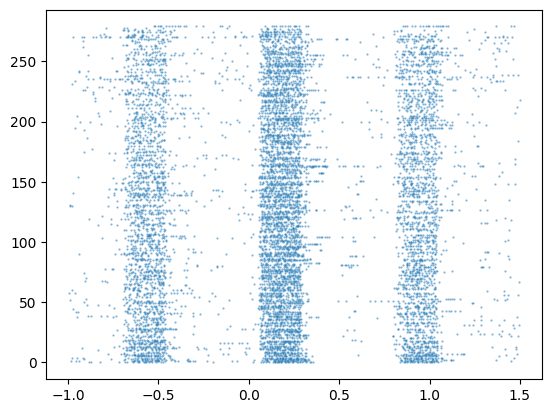

In [6]:
importlib.reload(pandas_method)

for unit_id in good_units.index.values[2:3]:

    df = pandas_method.align_spikes(
        spike_times[unit_id],
        change_times,
        (-1,1.5)
    )

plt.scatter(df.index.values, df.trial_index, c='tab:blue', s=0.35, alpha=0.5)

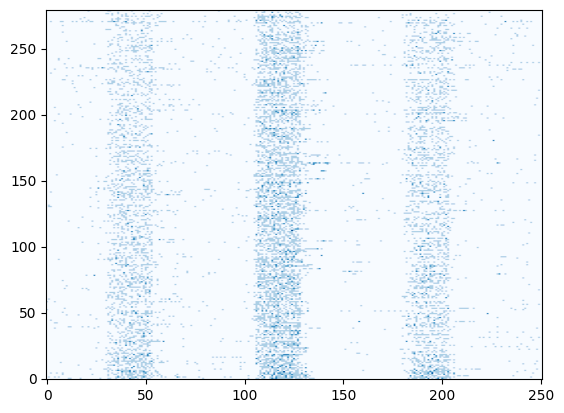

In [7]:
importlib.reload(pandas_method)

for unit_id in good_units.index.values[2:3]:

    counts = pandas_method.align_spikes(
        spike_times[unit_id],
        change_times,
        (-1,1.5),
        bin_size = 0.01
    )

plt.imshow(counts, origin='lower', aspect='auto', cmap='Blues')

In [8]:
import cProfile, pstats, io
from pstats import SortKey

pr = cProfile.Profile()
pr.enable()
counts = pandas_method.align_spikes(
        spike_times[unit_id],
        change_times,
        (-1,1.5),
        bin_size = 0.01
    )
pr.disable()
s = io.StringIO()
sortby = SortKey.TIME
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         183553 function calls (179709 primitive calls) in 0.225 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.095    0.095    0.095    0.095 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/pandas/core/indexes/interval.py:647(_get_indexer)
    32989    0.006    0.000    0.008    0.000 {built-in method builtins.isinstance}
        1    0.003    0.003    0.225    0.225 /home/joshs/GitHub/ephys-framework-tests/temporal-alignment/pandas_method.py:4(align_spikes)
      502    0.003    0.000    0.006    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/pandas/core/reshape/tile.py:623(_round_frac)
      280    0.003    0.000    0.008    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/numpy/lib/arraysetops.py:320(_unique1d)
      845    0.003    0.000    0.057    0.000 /home/joshs/anaconda3/envs/visual

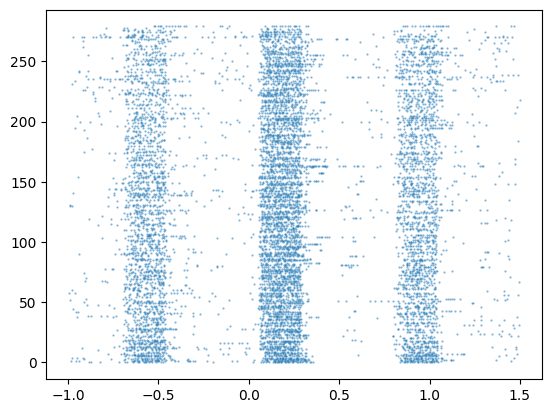

In [9]:
importlib.reload(numpy_method)

for unit_id in good_units.index.values[2:3]:

    ts, trial_inds = numpy_method.align_spikes(
        spike_times[unit_id],
        change_times,
        (-1,1.5)
    )

plt.scatter(ts, trial_inds, c='tab:blue', s=0.35, alpha=0.5)

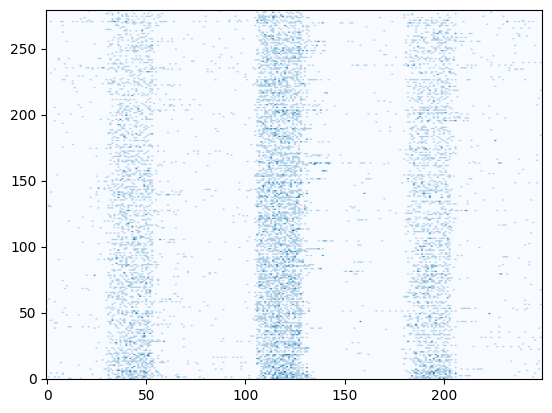

In [10]:
importlib.reload(numpy_method)

for unit_id in good_units.index.values[2:3]:

    bins, counts = numpy_method.align_spikes(
        spike_times[unit_id],
        change_times,
        (-1,1.5),
        bin_size = 0.01
    )

plt.imshow(counts, origin='lower', aspect='auto', cmap='Blues')

In [11]:
import cProfile, pstats, io
from pstats import SortKey

pr = cProfile.Profile()
pr.enable()
bins, counts = numpy_method.align_spikes(
        spike_times[unit_id],
        change_times,
        (-1,1.5),
        bin_size = 0.01
    )
pr.disable()
s = io.StringIO()
sortby = SortKey.TIME
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         17696 function calls (16016 primitive calls) in 0.028 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1120    0.004    0.000    0.004    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
 2520/840    0.003    0.000    0.023    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.003    0.003    0.028    0.028 /home/joshs/GitHub/ephys-framework-tests/temporal-alignment/numpy_method.py:3(align_spikes)
      280    0.003    0.000    0.019    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/numpy/lib/histograms.py:678(histogram)
      280    0.002    0.000    0.002    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/numpy/lib/function_base.py:1295(diff)
      280    0.002    0.000    0.006    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/numpy/lib

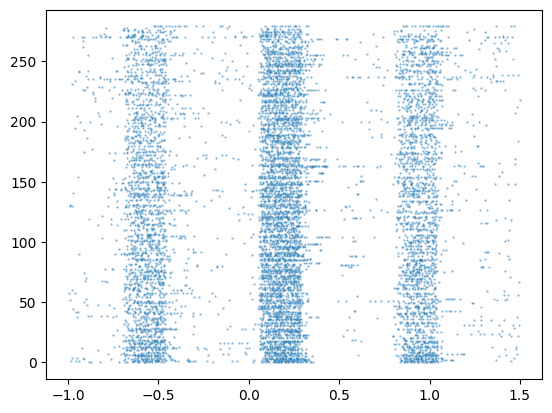

In [12]:
importlib.reload(pynapple_method)

tref = nap.Ts(change_times)

for unit_id in good_units.index.values[2:3]:

    data = nap.Ts(spike_times[unit_id])

    result = pynapple_method.compute_perievent(data, 
        tref, 
        (-1, 1.5))

for i, key in enumerate(result.keys()):
    t = result[key].index.values
    plt.scatter(t, np.zeros((t.shape))+i, c='tab:blue', s=0.35, alpha=0.5)

In [13]:
import cProfile, pstats, io
from pstats import SortKey

pr = cProfile.Profile()
pr.enable()
result = pynapple_method.compute_perievent(data, 
        tref, 
        (-1, 1.5))
pr.disable()
s = io.StringIO()
sortby = SortKey.TIME
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         2205880 function calls (2183717 primitive calls) in 1.614 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   488895    0.099    0.000    0.150    0.000 {built-in method builtins.isinstance}
        1    0.069    0.069    0.069    0.069 /home/joshs/GitHub/ephys-framework-tests/temporal-alignment/pynapple_method.py:8(align_to_event)
    14291    0.041    0.000    0.041    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     1680    0.041    0.000    0.712    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/pandas/core/reshape/tile.py:391(_bins_to_cuts)
   143447    0.035    0.000    0.050    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/pandas/core/dtypes/generic.py:43(_check)
4489/4486    0.034    0.000    0.134    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/pandas/core/indexes/base.py:397

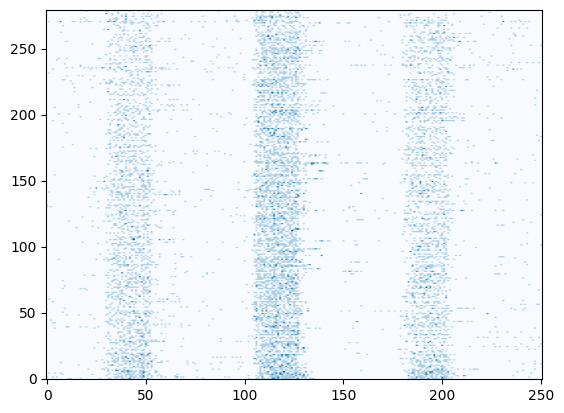

In [14]:
importlib.reload(ibl_method)

for unit_id in good_units.index.values[2:3]:

    raster, trs = ibl_method.get_event_aligned_raster(
        spike_times[unit_id], 
        change_times, tbin=0.01, epoch=[-1, 1.5], bin=True)

plt.imshow(raster, origin='lower', aspect='auto', cmap='Blues')

In [15]:
import cProfile, pstats, io
from pstats import SortKey

pr = cProfile.Profile()
pr.enable()
raster, trs = ibl_method.get_event_aligned_raster(
        spike_times[unit_id], 
        change_times, tbin=0.01, epoch=[-1, 1.5], bin=True)
pr.disable()
s = io.StringIO()
sortby = SortKey.TIME
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

         15779 function calls (15776 primitive calls) in 0.030 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  771/768    0.008    0.000    0.015    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.004    0.004    0.004    0.004 {method 'argsort' of 'numpy.ndarray' objects}
      504    0.003    0.000    0.004    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/numpy/core/numerictypes.py:573(_can_coerce_all)
      252    0.003    0.000    0.015    0.000 /home/joshs/anaconda3/envs/visual-behavior-neuropixels/lib/python3.8/site-packages/numpy/lib/index_tricks.py:322(__getitem__)
        1    0.002    0.002    0.030    0.030 /home/joshs/GitHub/ephys-framework-tests/temporal-alignment/ibl_method.py:63(get_event_aligned_raster)
        2    0.002    0.001    0.002    0.001 {built-in method numpy.arange}
     3522    0.001    0.000    0.001    0